The central package is tidyverse, which contains tidyr, dplyr, ggplot, etc. Other packages I am using are tidyquant for its nice ggplot theme, modelr, gridExtra and grid for additional plotting functionalities.

In [1]:
library(margins)
library(tidyverse)
library(tidyquant)
library(modelr)
library(gridExtra)
library(grid)
library(ggplot2)
library(parsedate)
library(readr)
library(RColorBrewer)

-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
√ ggplot2 3.2.1     √ purrr   0.3.2
√ tibble  2.1.1     √ dplyr   0.8.3
√ tidyr   0.8.3     √ stringr 1.4.0
√ readr   1.3.1     √ forcats 0.4.0
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
Loading required package: lubridate

Attaching package: 'lubridate'

The following object is masked from 'package:base':

    date

Loading required package: PerformanceAnalytics
Loading required package: xts
Loading required package: zoo

Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric

Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 

Attaching package: 'xts'

The following objects are masked from 'package:dplyr':

    first, last


Attaching package: 'PerformanceAnalytics'

The following object is masked from 'packag

# Reading in the data

In [2]:
dataset <- read_csv("ndouble11_test.csv")

Parsed with column specification:
cols(
  order_date = col_character(),
  invoice_date = col_character(),
  invoice_num = col_double(),
  cust_id = col_character(),
  country = col_character(),
  SumPurchases = col_double(),
  shipping_charge = col_double(),
  quantity = col_double(),
  stock_code = col_double(),
  tax = col_double(),
  description = col_character()
)


In [3]:
dataset <- dataset %>% 
 mutate(UnitPrice = SumPurchases/quantity,
  order_day = wday(dataset$invoice_date, label=T),
  order_hour = hour(dataset$invoice_date),
  order_min = minute(dataset$invoice_date),
  order_return = ifelse(SumPurchases >0, "order", "return"),
  province = country) 
glimpse(dataset)

Observations: 19,776
Variables: 17
$ order_date      <chr> "2019-11-11 0:29", "2019-11-11 0:29", "2019-11-11 0...
$ invoice_date    <chr> "2019-11-11 0:30", "2019-11-11 0:30", "2019-11-11 0...
$ invoice_num     <dbl> 7.156559e+13, 7.156559e+13, 7.156559e+13, 7.156559e...
$ cust_id         <chr> "余春<U+67AB>", "余春<U+67AB>", "<U+5F20>嘉<U+9759>", "<U+891A>慧芬", "大熊<U+5B9D>殿", "程程", "<U+53F6>素梅", "<U+53F6>...
$ country         <chr> "Chongqing", "Chongqing", "Yunnan", "Zhejiang", "Gu...
$ SumPurchases    <dbl> 0.40, 0.40, 100.80, 12.23, 111.36, 530.61, 6.61, 6....
$ shipping_charge <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
$ quantity        <dbl> 2, 2, 1, 1, 4, 6, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, ...
$ stock_code      <dbl> 5.37183e+11, 5.47073e+11, 5.50601e+11, 5.86484e+11,...
$ tax             <dbl> 0.00, 0.00, 8.41, 2.59, 19.52, 52.97, 3.39, 3.39, 2...
$ description     <chr> "테크 울드라이 용기 1500ML 세탁세제", "테크 울드라이 1300ML", "RE닥터그루...
$ UnitPrice       <dbl> 0.200, 0.200, 10

# Exploratory Data Analysis (EDA)
Transactions by country

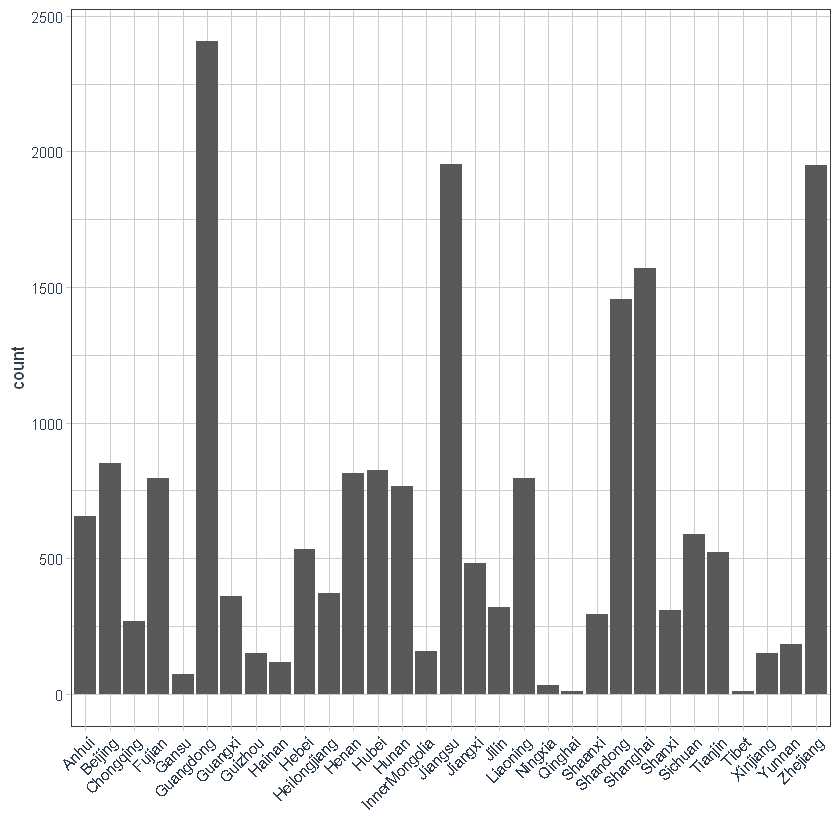

In [5]:
x1 <- dataset %>%
 ggplot(aes(country))+ geom_bar()+
 scale_fill_manual(values = palette_light()) +
 theme_tq() +
 theme(legend.position = "right") +
 theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1)) +
 labs(x = "",
  fill = "")
x1

Transactions over time
- To get an idea of the number of transactions over time, we can use a frequency polygon. Here, we can see that the number purchases slightly increased during the last two months of recording, while the number of returns remained relatively stable.

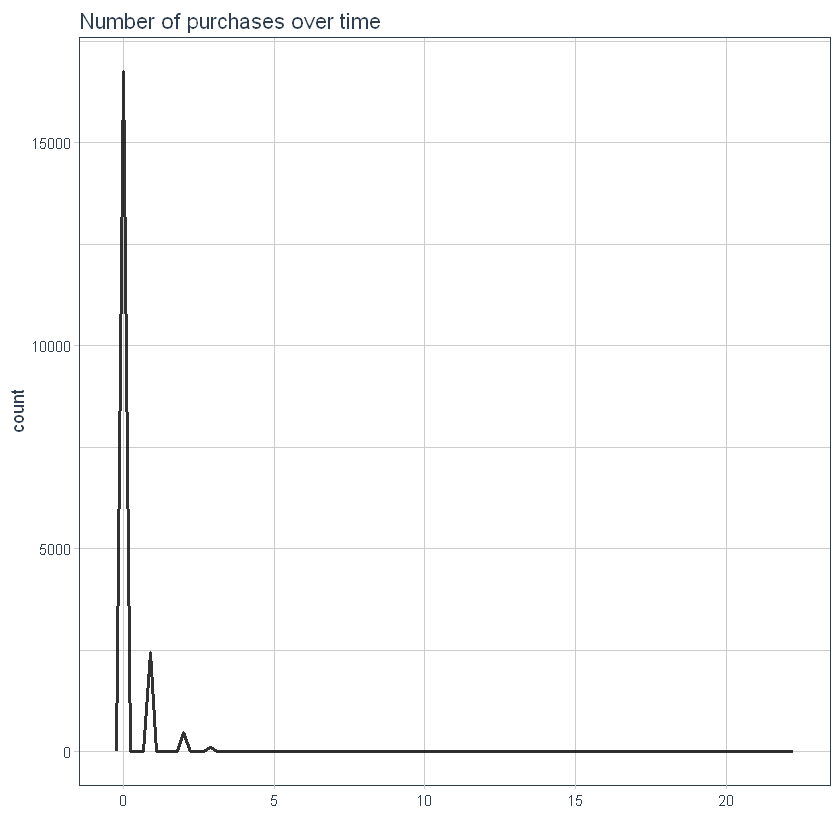

In [6]:
x2 <- dataset %>%
 ggplot(aes(x = order_hour)) +
 geom_freqpoly(bins = 100, size = 1, alpha = 0.8) +
 scale_color_manual(values = palette_light()) +
 theme_tq() +
 guides(color = FALSE) +
 labs(title = "Number of purchases over time",
  x = "")
x2

Income/loss from transactions
- Let’s look at the income/loss from transactions over time. Here, we plot the sum of income and losses for each day. The income seems to increase slightly during the last month, while losses remained more stable. The only severe outlier is the last day.

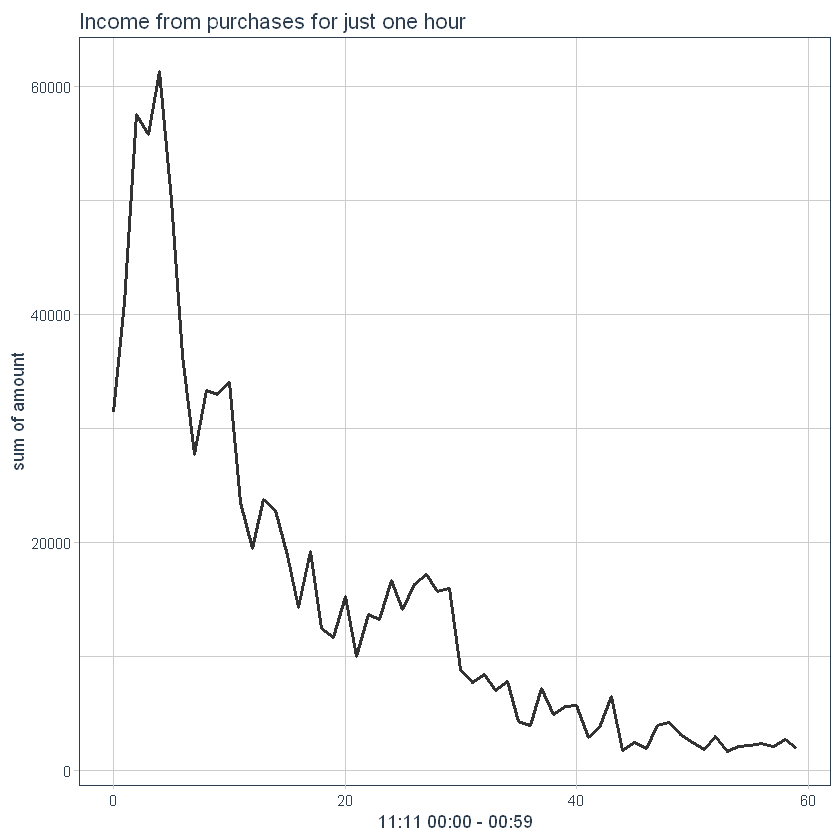

In [7]:
x3 <- dataset %>%
 filter(order_hour==0) %>% 
 group_by(order_min) %>%
 summarise(Total_amount = sum(SumPurchases)) %>%
 ggplot(aes(x = order_min, y = Total_amount)) +
 geom_line(size = 1, alpha = 0.8) +
 scale_color_manual(values = palette_light()) +
 theme_tq() +
 guides(color = FALSE) +
 labs(title = "Income from purchases for just one hour",
  x = "11:11 00:00 - 00:59",
  y = "sum of amount",
  color = "")
x3

Transactions by day and time

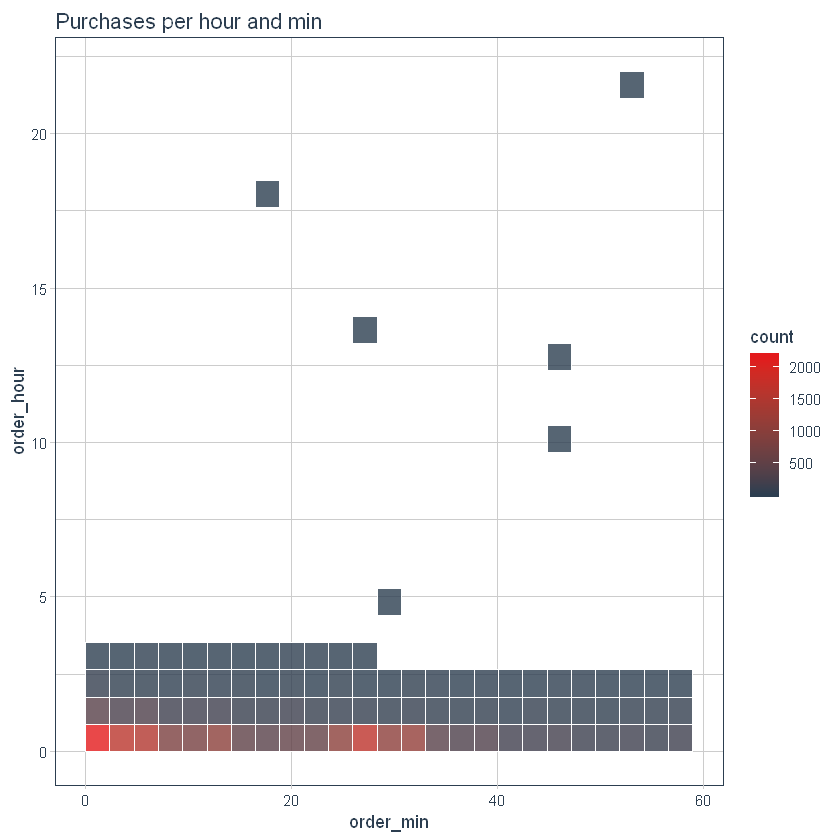

In [8]:
x4 <- dataset %>%
 ggplot(aes(x = order_min, y = order_hour)) +
 stat_bin2d(alpha = 0.8, bins = 25, color = "white") +
 scale_fill_gradientn(colours = c(palette_light()[[1]], palette_light()[[2]])) +
 theme_tq() +
 theme(legend.position = "right") +
 labs(title = "Purchases per hour and min")
x4

Items ; Also of interest are the items that are being purchases the most. Here, we sum up the net quantities for each item.

In [15]:
dataset %>% 
 group_by(stock_code, description) %>% 
 summarise(sum = sum(quantity)) %>% 
 arrange(-sum) %>% 
 head(20)

stock_code,description,sum
5.96291e+11,윤고 더 퍼스트 400ml+50ml(신)_기획,5210
5.47073e+11,테크 울드라이 1300ML,3752
5.37183e+11,테크 울드라이 용기 1500ML 세탁세제,3724
5.37297e+11,페리오 토탈 7 마일드 120g,2256
5.40352e+11,FiJi시트세제 30매*2,1897
5.98468e+11,온)보타니크 바디워시 레몬&노니 500mL,1185
5.42578e+11,죽염 잇몸고 펌프 치약 285g*2+V죽염 칫솔 잇몸전문 2+1입_베,999
5.50601e+11,RE닥터그루트 지성두피용 샴푸 400ml+ RE닥터그루트 지성두피용 200ml 증정,844
5.86269e+11,염모제 스마트염색(원터치)_자연갈색,500
5.72042e+11,죽염 히말라야 플로럴민트 100g,472


As we can see in the plots below, the majority of items is purchases only occasionally, while a few items are purchased a lot.

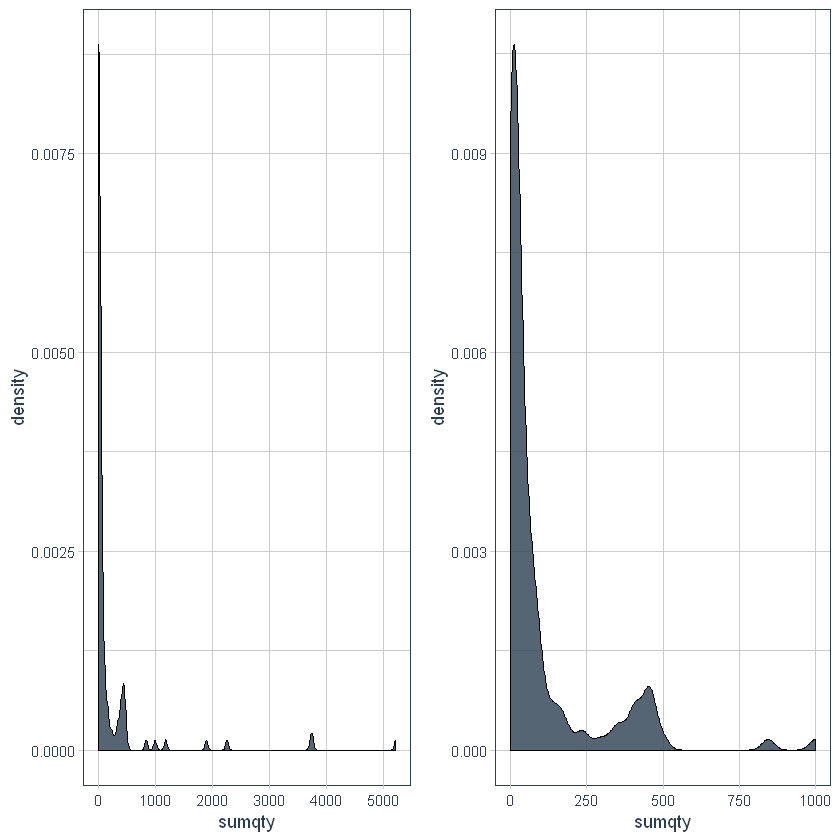

In [27]:
p1 <- dataset %>%
 group_by(stock_code, description) %>% 
 summarise(sumqty = sum(quantity)) %>% 
 ggplot(aes(x = sumqty)) +
 geom_density(fill = palette_light()[[1]], alpha = 0.8) +
 theme_tq()

p2 <- dataset %>%
 group_by(stock_code, description) %>% 
 summarise(sumqty = sum(quantity)) %>% 
 filter(sumqty>0 & sumqty<1000) %>%
 ggplot(aes(x = sumqty)) +
 geom_density(fill = palette_light()[[1]], alpha = 0.8) +
 theme_tq()

grid.arrange(p1, p2, widths = c(0.5, 0.5))

We can also calculate on how many different hours, items have been purchased.

In [30]:
most_sold <- dataset %>%
 group_by(order_hour, stock_code, description) %>%
 summarise(sum = sum(quantity)) %>%
 group_by(order_hour,description) %>%
 arrange(order_hour,-sum)
head(most_sold,5)
least_sold <- dataset %>%
 group_by(order_hour, stock_code, description) %>%
 summarise(sum = sum(quantity)) %>%
 group_by(order_hour,description) %>%
 arrange(order_hour,-sum)
tail(most_sold,5)

order_hour,stock_code,description,sum
0,5.47073e+11,테크 울드라이 1300ML,3426
0,5.37183e+11,테크 울드라이 용기 1500ML 세탁세제,3398
0,5.96291e+11,윤고 더 퍼스트 400ml+50ml(신)_기획,3025
0,5.37297e+11,페리오 토탈 7 마일드 120g,2154
0,5.40352e+11,FiJi시트세제 30매*2,1694


order_hour,stock_code,description,sum
10,5.73353e+11,온)플)아이리스 바디워시500g_12입(y16),1
13,5.49272e+11,귀애랑 중형 18P*3+ON 12P*1 + 슈퍼롱 10P*1 + 소형 *1,1
14,5.58186e+11,행복 가득 E 1호(A7),1
18,5.40352e+11,오가니스트 발효초 샴푸 500ml,1
22,5.40352e+11,오가니스트 체리불러썸 샴푸500ml+오가니스트 체리불러썸 컨디500ml+오가)로즈마리&민트샴푸200ML,1


Let’s look at Yungo & Tech's distribution of sold quantities per day

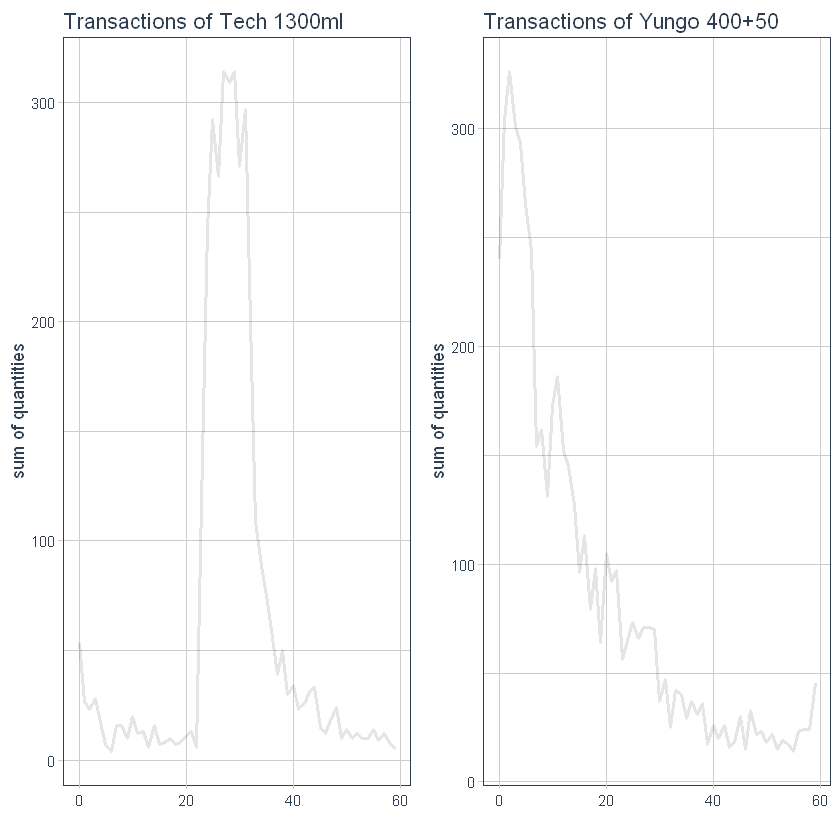

In [31]:
x5 <- 
dataset %>%
 filter(stock_code == 547073000000) %>%
 group_by(order_min) %>%
 summarise(sum = sum(quantity)) %>%
 ggplot(aes(x = order_min, y = sum)) +
 geom_line(size = 1, alpha = 0.1) +
 scale_color_manual(values = palette_light()) +
 theme_tq() +
 labs(x = "",
  y = "sum of quantities",
  color = "",
  title = "Transactions of Tech 1300ml")

x6 <- 
 dataset %>%
 filter(stock_code == 596291000000) %>%
 group_by(order_min) %>%
 summarise(sum = sum(quantity)) %>%
 ggplot(aes(x = order_min, y = sum)) +
 geom_line(size = 1, alpha = 0.1) +
 scale_color_manual(values = palette_light()) +
 theme_tq() +
 labs(x = "",
  y = "sum of quantities",
  color = "",
  title = "Transactions of Yungo 400+50")

grid.arrange(x5, x6, widths = c(0.5, 0.5))

I've always been trying to have a quick glimpse of what's happing, so i just wanted to give it a try for a scarping tmall reviews with rvest that i learned!
But, long story short, i've  failed more than 10 times to scrap those review..
let's have a quick look what i have done to make it roll..

###rvest -  
결과 값 : 
{xml_document}
<html>
[1] <head>\n<meta http-equiv="Content-Type" content="te ...
[2] <body class="  no7day" data-spm="1000855">\n<script ...

In [8]:
library(rvest)
url <- 'https://detail.tmall.hk/item.htm?spm=a220m.1000858.1000725.1.6ad6297cof43fi&id=600052650795&skuId=4188286968549&user_id=2549234913&cat_id=52792006&is_b=1&rn=240fefacc0ab303bf5c7f9b55ef15623'

doc <- read_html(url)
 html_nodes("tm-rate-fulltxt") %>% 
 html_text()

ERROR: Error in UseMethod("xml_find_all"): 클래스 "character"의 객체에 적용된 'xml_find_all'에 사용할수 있는 메소드가 없습니다


##phantomjs - 
결과 값 : 
{xml_document}
<html>
[1] <body>\n<p>// scrape_dow.js \r\n var webPage = requ ...

In [10]:
writeLines(sprintf("var page = require('webpage').create();
page.open('%s', function () {
  console.log(page.content); //page source
  phantom.exit();
  });", url), con="scrape.js")
 
 system("phantomjs scrape.js > scrape.html")
 
 page_html <- html("scrape.html")
 page_html %>% html_nodes('class') %>% html_table()
page_html

Warning message in system("phantomjs scrape.js > scrape.html"):
"'phantomjs' not found"

[1] 127

ERROR: Error: 'scrape.html' does not exist in current working directory ('C:/Users/seung/OneDrive/R/Rstudy_Dangsan/R1129').


##rselenium - 성공

In [11]:
library(RSelenium)
remDr <- remoteDriver(port=4445L, browserName="chrome") 
remDr$open() 
remDr$navigate("https://detail.tmall.hk/item.htm?spm=a220m.1000858.1000725.1.6ad6297cof43fi&id=600052650795&skuId=4188286968549&user_id=2549234913&cat_id=52792006&is_b=1&rn=240fefacc0ab303bf5c7f9b55ef15623")

[1] "Connecting to remote server"
$acceptInsecureCerts
[1] FALSE

$browserName
[1] "chrome"

$browserVersion
[1] "78.0.3904.108"

$chrome
$chrome$chromedriverVersion
[1] "78.0.3904.105 (60e2d8774a8151efa6a00b1f358371b1e0e07ee2-refs/branch-heads/3904@{#877})"

$chrome$userDataDir
[1] "C:\\Users\\seung\\AppData\\Local\\Temp\\scoped_dir15064_134799492"


$`goog:chromeOptions`
$`goog:chromeOptions`$debuggerAddress
[1] "localhost:61243"


$networkConnectionEnabled
[1] FALSE

$pageLoadStrategy
[1] "normal"

$platformName
[1] "windows nt"

$proxy
named list()

$setWindowRect
[1] TRUE

$strictFileInteractability
[1] FALSE

$timeouts
$timeouts$implicit
[1] 0

$timeouts$pageLoad
[1] 300000

$timeouts$script
[1] 30000


$unhandledPromptBehavior
[1] "dismiss and notify"

$webdriver.remote.sessionid
[1] "d8dd8bb2b280ac7ca72d62e1b403f36a"

$id
[1] "d8dd8bb2b280ac7ca72d62e1b403f36a"



In [13]:
html <- remDr$getPageSource()[[1]]
html <- read_html(html)

In [14]:
review_obd <- html %>% 
 html_nodes('.tm-rate-fulltxt') %>% 
 html_text()
review_obd

[1] "洗完挺滋<U+6DA6>的，不干，也不粘，<U+5F88>舒服，味道<U+5F88>好<U+95FB>，就是不持久"                                                                                                                                                                    
 [2] "<U+74F6>子<U+5F88>可<U+7231> 相信用起<U+6765><U+5E94><U+8BE5>不<U+9519>"                                                                                                                                                                               
 [3] "<U+74F6>子<U+5F88>可<U+7231>  相信用起<U+6765><U+5E94><U+8BE5>不<U+9519>"                                                                                                                                                                              
 [4] "好香好香，好喜<U+6B22>，洗的身上好舒服，而且香味<U+5F88>持久，非常推<U+8350>，而且<U+74F6>子的<U+8D28>感也非常好，洗了<U+51E0>天，洗完以后，身<U+4F53>滑滑的"                                                                                          
 [5] "沐浴露味道<U+5F88>好<U+95FB>～本<U+6765>想<U+4E70>不同的味道的可惜都<U+5356>完了。不<U+8FC7><U+67E0><U+6AAC><U+771F>的好<U+6E05>新，是那<U+79CD>淡淡的<U+67E0><U+6AAC>茶的味道，超好<U+95FB>。不<U+9519>不<U+9519>不<U+9519>不<U+9519>不<U+9519>不<U+9519>不<U+9519>不<U+9519>不<U+9519>不<U+9519>不<U+9519>不<U+9519>不<U+9519>不<U+9519>不<U+9519>不<U+9519>不<U+9519>不<U+9519>不<U+9519>不<U+9519>不<U+9519>不<U+9519>不<U+9519>不<U+9519>不<U+9519>不<U+9519>不<U+9519>不<U+9519>不<U+9519>不<U+9519>不<U+9519>不<U+9519>不<U+9519>不<U+9519>不<U+9519>"
 [6] "太好<U+95FB>了，<U+67E0><U+6AAC>的太喜<U+6B22>了，<U+989C><U+503C>喜<U+6B22>，我也不知道沐浴露能用到<U+5565><U+65F6>候，家里太多了"                                                                                                                    
 [7] "看人家推<U+8350><U+4E70>的，<U+74F6>子<U+5F88>好看，昨天拿到老公<U+8BF4>像<U+5976>茶，哈哈……"                                                                                                                                                        
 [8] "看人家推<U+8350><U+4E70>的，<U+74F6>子<U+5F88>好看，昨天拿到老公<U+8BF4>像<U+5976>茶，哈哈……"                                                                                                                                                        
 [9] "小巧玲<U+73D1>， <U+5F88>喜<U+6B22>。"                                                                                                                                                                                                                 
[10] "味道<U+5F88><U+6E05>新 超好<U+95FB> <U+51E0>乎<U+6CA1>有什<U+4E48>生姜味 泡泡挺多的"                                                                                                                                                                   
[11] "<U+4E70>了一大箱 包的<U+4E25><U+4E25><U+5B9E><U+5B9E>的 <U+6EE1>意 洗<U+53D1>水和沐浴露一直在<U+8FD9>里<U+4E70> <U+8FD9>次<U+8FD8><U+7ED9><U+5988><U+5988><U+4E70>了泡沫染<U+53D1><U+5242> 希望好用"                                                   
[12] "<U+989C><U+503C>高，味道<U+5F88>好<U+95FB>，<U+6E05>新<U+67E0><U+6AAC>的味道，泡沫<U+7EC6><U+817B>，好<U+51B2>洗，不假滑"                                                                                                                              
[13] "味道<U+5F88><U+6E05>新 超好<U+95FB> 泡泡挺多的 <U+5F88>滋<U+6DA6>"                                                                                                                                                                                     
[14] "味道<U+8FD8>可以，挺好<U+95FB>的，而且用着<U+5F88>舒服，不假滑"                                                                                                                                                                                        
[15] "<U+8FD8><U+6CA1>用 沐浴露<U+5F88>大一<U+74F6> 包<U+88C5><U+5F88>好"                                                                                                                                                                                    
[16] "<U+53CC>十一<U+4E70>的<U+8FD9>款沐浴露<U+5F88><U+7EC6><U+817B>，<U+67E0><U+6AAC>味<U+5F88><U+6E05>新，泡沫<U+4E30>富，<U+86EE>好用的，准<U+5907><U+53CC>十二再<U+4E70><U+4E2A>桑<U+845A>味道的"                                                        
[17] "味道好<U+95F

eventually, yay! but i am still not really aware of clicking to the next page to crawl all the datas belonged to,
anyway since i don't really have much time to sleep on it, I had to move on to the next step ; word cloud!

In [29]:
library(jiebaR)
library(wordcloud2) 
library(RColorBrewer)

In [30]:
seg <- qseg[review_obd]
seg <- seg[nchar(seg)>1]
seg <- table(seg)
seg <- sort(seg, decreasing = TRUE)
seg

seg
不<U+9519>     味道 好<U+95FB> <U+6E05>新 <U+74F6>子   沐浴露 喜<U+6B22> <U+67E0><U+6AAC> 
      37       13       10        5        5        5        5        4 
推<U+8350>     泡沫 <U+7EC6><U+817B> <U+989C><U+503C>     不假     舒服     而且 <U+51B2>洗 
       4        4        3        3        3        3        3        2 
<U+53CC>十 <U+5976>茶 <U+5E94><U+8BE5> <U+6CA1>有 可<U+7231> 起<U+6765>     拿到     老公 
       2        2        2        2        2        2        2        2 
    非常     相信     洗完     人家 滋<U+6DA6>     昨天     持久 包<U+88C5> 
       2        2        2        2        2        2        2        2 
    泡泡     哈哈     好看 <U+4E25><U+4E25><U+5B9E><U+5B9E> <U+4E25><U+5B9E> <U+4E30>富 <U+4E70><U+4E2A> <U+51E0>天 
       2        2        2        1        1        1        1        1 
<U+51E0>乎 <U+5356>完 <U+5565><U+65F6>候 <U+5988><U+5988> <U+5B9E>惠 <U+5F88>大 <U+5F88>香 <U+635F><U+574F> 
       1        1        1        1        1        1        1        1 
<U+67E0><U+6AAC>茶 <U+6CA1>用 <U+6EE1>意

In [35]:
set.seed(100)
wordcloud2(seg, size=2, color = "random-light", backgroundColor = "grey")
dev.off()

HTML widgets cannot be represented in plain text (need html)

wordcloud package는 계속 중국어를 불러오는데에 인코딩 오류를 일으킴,
wordcloud2가 이뻐서 넣어봤더니, 중국어를 정확히 인식해서 불러옴! 
read_csv, read.csv 의 차이와 같은.. 인식도에 대한 성능 차이가 있는 것 같음